In [64]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Legend,  Toggle, LegendItem, CustomJS, Select, Button
from bokeh.palettes import Category20
from bokeh.layouts import column
import os

# LinkedIn Industry Performance Analysis: Algeria 2017-2025

This notebook analyses LinkedIn Hiring Rate, Skills and Skills Penetration by Gender in Algeria. 

## LinkedIn Hiring Rate

In [65]:
COUNTRY = 'Algeria'
os.environ['COUNTRY'] = COUNTRY

In [66]:
def clean_linkedin_data(excel_file):
    """Clean and prepare LinkedIn data from Excel file."""
    try:
        # Load the specific sheet with correct header row
        data_corrected = pd.read_excel(excel_file, sheet_name="2B - LHR by Ctry, Ind", header=3)
        
        # Rename columns and clean data
        data_cleaned = data_corrected.rename(columns={
            'Unnamed: 1': 'Month',
            'Unnamed: 2': 'Country',
            'Unnamed: 3': 'Industry',
            'Unnamed: 4': 'LHR (YOY)'
        })
        
        # Remove rows with missing data
        data_cleaned = data_cleaned.dropna(subset=['Month', 'Country', 'Industry', 'LHR (YOY)'])
        
        # Remove the first row (duplicate headers)
        data_cleaned = data_cleaned.iloc[1:]
        
        # Remove the column containing only NaN values
        data_cleaned = data_cleaned.drop(columns=['Unnamed: 0'])
        
        return data_cleaned
        
    except Exception as e:
        print(f"Error during data cleaning: {str(e)}")
        return None

In [67]:
def create_industry_performance_plots(excel_file):
    """Create interactive plots showing industry performance in Algeria, with toggle to filter from 2022."""
    output_notebook()

    try:
        # Clean the data
        df = clean_linkedin_data(excel_file)
        if df is None:
            print("Data cleaning failed. Please check your Excel file.")
            return

        # Filter data for Algeria
        country = os.getenv('COUNTRY')
        bd_data = df[df['Country'] == country].copy()

        # Convert Month to datetime
        bd_data['Month'] = pd.to_datetime(bd_data['Month'])

        # Calculate average LHR for each industry
        industry_avg = bd_data.groupby('Industry')['LHR (YOY)'].mean().sort_values(ascending=False)

        # Split industries into quartiles (5 industries each)
        top_5 = industry_avg.head(5).index.tolist()
        upper_mid_5 = industry_avg.iloc[5:10].index.tolist()
        lower_mid_5 = industry_avg.iloc[10:15].index.tolist()
        bottom_5 = industry_avg.iloc[15:].index.tolist()

        # Define quartile categories
        categories = [
            ('Leading Industries', top_5, 'Top Performing Industries (1st Quartile)'),
            ('Growing Industries', upper_mid_5, 'Strong Performing Industries (2nd Quartile)'),
            ('Transitioning Industries', lower_mid_5, 'Moderate Performing Industries (3rd Quartile)'),
            ('Emerging Industries', bottom_5, 'Developing Industries (4th Quartile)')
        ]

        tabs = []

        # Create one tab per industry category
        for tab_title, industries, plot_title in categories:
            # Prepare full and filtered data
            plot_data_full = bd_data[bd_data['Industry'].isin(industries)].copy()
            plot_data_filtered = plot_data_full[plot_data_full['Month'] >= '2022-01-01'].copy()

            # Create figure
            p = figure(
                title=f"LinkedIn Hiring Rate: {plot_title} in Algeria",
                x_axis_type='datetime',
                width=800,
                height=500,
                background_fill_color="#f8f9fa"
            )

            legend_items = []
            js_sources = []

            for i, industry in enumerate(industries):
                color = Category20[10][i]

                full_industry_data = plot_data_full[plot_data_full['Industry'] == industry]
                filtered_industry_data = plot_data_filtered[plot_data_filtered['Industry'] == industry]

                source = ColumnDataSource(full_industry_data)
                source_full = ColumnDataSource(full_industry_data)
                source_filtered = ColumnDataSource(filtered_industry_data)

                line = p.line(
                    x='Month',
                    y='LHR (YOY)',
                    source=source,
                    line_width=3,
                    color=color
                )

                legend_items.append((f"{industry} (Avg: {industry_avg[industry]:.2f}%)", [line]))
                js_sources.append({'source': source, 'full': source_full, 'filtered': source_filtered})

            # Add hover
            p.add_tools(HoverTool(
                tooltips=[
                    ("Month", "@Month{%b %Y}"),
                    ("LHR (YOY)", "@{LHR (YOY)}{0.00}%"),
                    ("Industry", "@Industry")
                ],
                formatters={"@Month": "datetime"},
                mode='vline'
            ))

            # Axes labels and styling
            p.xaxis.axis_label = 'Month'
            p.yaxis.axis_label = 'LinkedIn Hiring Rate (YOY %)'
            p.xaxis.axis_label_text_font_size = '12pt'
            p.yaxis.axis_label_text_font_size = '12pt'
            p.xaxis.major_label_text_font_size = '10pt'
            p.yaxis.major_label_text_font_size = '10pt'
            p.title.text_font_size = '14pt'
            p.grid.grid_line_color = "gray"
            p.grid.grid_line_alpha = 0.3

            # Add legend
            legend = Legend(
                items=legend_items,
                orientation='horizontal',
                spacing=20,
                padding=10,
                click_policy="hide",
                label_text_font_size='9pt',
                border_line_color="gray",
                border_line_alpha=0.5,
                background_fill_alpha=0.7,
                nrows=3
            )
            p.add_layout(legend, 'below')

            # Toggle button
            toggle = Toggle(label="Filter from 2022", button_type="success", active=False)

            # JS callback
            callback_code = """
                for (let i = 0; i < sources.length; i++) {
                    sources[i].data = toggle.active ? filtered[i].data : full[i].data;
                    sources[i].change.emit();
                }
                toggle.label = toggle.active ? 'Show full range' : 'Filter from 2022';
                toggle.button_type = toggle.active ? 'warning' : 'success';
        """

            callback = CustomJS(args={
                "toggle": toggle,
                "sources": [src['source'] for src in js_sources],
                "full": [src['full'] for src in js_sources],
                "filtered": [src['filtered'] for src in js_sources]
                }, code=callback_code)

            toggle.js_on_change("active", callback)

            # Combine toggle and plot
            tab_layout = column(toggle, p)
            tab = TabPanel(child=tab_layout, title=tab_title)
            tabs.append(tab)

        # Show tabs
        if tabs:
            tabs_layout = Tabs(tabs=tabs)
            show(tabs_layout)
        else:
            print("No data available for visualization.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your Excel file structure and column names.")



In [68]:
def export_industry_metrics(excel_file, output_path='industry_performance_metrics.csv'):
    """Export industry performance metrics to CSV file."""
    try:
        # Clean the data
        df = clean_linkedin_data(excel_file)
        
        if df is None:
            return None
            
        # Filter data for Algeria
        bd_data = df[df['Country'] == 'Algeria'].copy()
        bd_data['Month'] = pd.to_datetime(bd_data['Month'])
        
        # Calculate metrics for each industry
        metrics_list = []
        for industry in bd_data['Industry'].unique():
            industry_data = bd_data[bd_data['Industry'] == industry]
            
            # Calculate various metrics
            metrics = {
                'Industry': industry,
                'Average_LHR': industry_data['LHR (YOY)'].mean(),
                'Max_LHR': industry_data['LHR (YOY)'].max(),
                'Min_LHR': industry_data['LHR (YOY)'].min(),
                'Volatility': industry_data['LHR (YOY)'].std(),
                'Latest_LHR': industry_data.loc[industry_data['Month'].idxmax(), 'LHR (YOY)'],
                'Growth_Trend': industry_data['LHR (YOY)'].iloc[-1] - industry_data['LHR (YOY)'].iloc[0],
                'Start_Date': industry_data['Month'].min().strftime('%Y-%m'),
                'End_Date': industry_data['Month'].max().strftime('%Y-%m')
            }
            metrics_list.append(metrics)
        
        # Create DataFrame and sort by Average LHR
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df = metrics_df.sort_values('Average_LHR', ascending=False)
        
        # Add category labels
        n_industries = len(metrics_df)
        categories = ['Leading Industries'] * 5 + \
                    ['Growing Industries'] * 5 + \
                    ['Transitioning Industries'] * 5 + \
                    ['Emerging Industries'] * 5
        metrics_df['Category'] = categories[:n_industries]
        
        # Reorder columns to put Category first
        cols = ['Category'] + [col for col in metrics_df.columns if col != 'Category']
        metrics_df = metrics_df[cols]
        
        # Export to CSV
        metrics_df.to_csv(output_path, index=False)
        print(f"Metrics exported to {output_path}")
        
        return metrics_df
        
    except Exception as e:
        print(f"Error exporting metrics: {str(e)}")
        return None

# Example usage:
file_path = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
metrics_df = export_industry_metrics(file_path, '../../data/LinkedIn/processed/Algeria_industry_metrics.csv')

Metrics exported to ../../data/LinkedIn/processed/Algeria_industry_metrics.csv


In [69]:
file_path = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
create_industry_performance_plots(file_path)

Loading BokehJS ...

In [70]:
df = clean_linkedin_data(file_path)

In [71]:
from tabulate import tabulate
industry_grouping = metrics_df.groupby(['Category'])[['Average_LHR', 'Max_LHR','Min_LHR', 'Volatility', 'Growth_Trend']].mean().reset_index()
headers = ['Average LHR', 'Max LHR', 'Min LHR', 'Volatility (STD)', 'Growth Trend (2017-2025)']
print(tabulate(industry_grouping, headers=headers,tablefmt='fancy_grid'))

╒════╤══════════════════════════╤═══════════════╤═══════════╤═══════════╤════════════════════╤════════════════════════════╕
│    │                          │   Average LHR │   Max LHR │   Min LHR │   Volatility (STD) │   Growth Trend (2017-2025) │
╞════╪══════════════════════════╪═══════════════╪═══════════╪═══════════╪════════════════════╪════════════════════════════╡
│  0 │ Emerging Industries      │     -0.204222 │   0.61155 │  -0.504   │           0.252748 │                  -0.036875 │
├────┼──────────────────────────┼───────────────┼───────────┼───────────┼────────────────────┼────────────────────────────┤
│  1 │ Growing Industries       │      0.229189 │   4.93574 │  -0.80098 │           0.849302 │                  -0.30158  │
├────┼──────────────────────────┼───────────────┼───────────┼───────────┼────────────────────┼────────────────────────────┤
│  2 │ Leading Industries       │      0.460806 │   9.21272 │  -0.57202 │           1.24449  │                  -0.14782  │
├────┼──

# 🇩🇿 **Insights: Algeria**

The LinkedIn dataset for Algeria covers 20 industries, grouped into four quartiles according to their **average year-on-year hiring rate (LHR)** between 2017 and 2025. The quartiles reflect different growth and volatility patterns in the Algerian labor market.

---

### **Quartile #1: Leading Industries (avg LHR: 0.29–0.77%)**

* **Real Estate and Equipment Rental Services** leads with an average LHR of **0.77%**, the highest among all industries. It shows **moderate volatility (0.42%)**, suggesting relatively stable yet sustained growth across the period. (Note: this industry only has two data points)
* **Accommodation and Food Services** exhibits **high volatility (2.13%)**, with LHRs ranging from **-0.93% to 17.79%**, reflecting year-to-year spikes related to reopening after COVID-19 (5/1/21). Despite this volatility, its **growth trend remains positive (+0.21%)**.
* **Retail** and **Consumer Services** show weaker performance, both experiencing **negative growth trends (-1.38% and -0.17%)** and ending February 2025 with negative hiring rates.
* **Education**, while having the lowest average LHR in this group (**0.29%**), maintains **near-zero volatility (0.86%)** and a **stable growth trend (+0.004%)**.

> In short, Algeria’s “leading” sectors are dynamic but volatile. The hospitality and retail segments have seen sharp cycles, while education and real estate provide steadier employment momentum.

---

### **Quartile #2: Growing Industries (avg LHR: 0.20–0.26%)**

* **Hospitals and Health Care** tops this group with an average LHR of **0.26%**, though its **growth trend is negative (-0.85%)**, implying contraction after a strong 2021–22 period.
* **Transportation, Logistics, Supply Chain and Storage** maintains a **steady LHR (0.22%)** and **moderate volatility (0.72%)**, though it too shows **slight negative growth (-0.20%)**.
* **Government Administration** stands out with a **positive growth trend (+0.75%)**, indicating gradual hiring increases over time.
* **Financial Services** and **Entertainment Providers** both show **high volatility (~1%)** and **declining trends**, suggesting cyclical activity but limited sustained expansion.

---

### **Quartile #3: Transitioning Industries (avg LHR: 0.10–0.16%)**

* **Wholesale** and **Construction** have average LHRs of **0.16%** and **0.12%**, with moderate volatility (~0.65–0.69%). Construction shows **a mild positive trend (+0.12%)**, suggesting a potential rebound in hiring activity, while wholesale shows  a **negative growth trend (-0.39%)**.
* **Technology, Information, and Media** has an average LHR of **0.13%**, moderate volatility (**0.41%**), and a **neutral growth trend (+0.02%)**, indicating steady but limited digital hiring.
* **Professional Services** shows the **lowest volatility (0.37%)** in this group, suggesting relative stability despite a **negative growth trend (-0.39%)**.
* **Manufacturing** records **slightly higher volatility (0.61%)** and **negative growth (-0.18%)**, reflecting slower recovery in traditional production sectors.

> These “transitioning” industries display mixed trajectories: **construction** and **technology** are stabilizing, while **wholesale**, **manufacturing** and **professional services** are showing signs of contraction.

---

### **Quartile #4: Emerging Industries (avg LHR: -0.53–0.10%)**

* **Oil, Gas, and Mining**, traditionally Algeria’s key export sector, has an **average LHR of 0.10%** but a **negative growth trend (-0.44%)**, reflecting cyclical activity with limited net job creation.
* **Utilities** shows an **average LHR of -0.16%** and the second **lowest volatility (0.13%)**. (Note: this industry only has two data points)
* **Administrative and Support Services** reports a **negative average LHR (-0.22%)** but a **strong positive growth trend (+0.43%)**, suggesting a recent uptick in hiring momentum. (Note: this industry only has two data points)
* **Farming, Ranching, and Forestry** has the **lowest average LHR (-0.53%)** but a **slight positive growth (+0.06%)**. (Note: this industry only has two data points)

---

### **Overall Observations**

* Across all industries, **volatility is present**, with multiple sectors showing large hiring swings (some exceeding ±10%).
* Overall **growth trends are mostly negative**, meaning that current momentum is driven by past peaks rather than sustained expansion.
* **Government Administration** and **Real Estate and Equipment Rental Services** are the only sectors with clear positive growth trends and positive latest LHR.

## Skills Distribution Analysis in Algeria's Labor Market

This analysis shows the top skills in each industries from LinkedIn skills assumed and mentioned by its users. 

In [72]:
def create_industry_performance_dict(excel_file):
    """Create a dictionary with industry performance metrics split into 4 quartiles."""
    try:
        # Clean data
        df = clean_linkedin_data(excel_file)
        
        if df is None:
            return None
            
        # Filter data for Algeria and convert Month to datetime
        bd_data = df[df['Country'] == 'Algeria'].copy()
        bd_data['Month'] = pd.to_datetime(bd_data['Month'])
        
        # Initialize performance dictionary with 4 quartiles
        performance_dict = {
            'leading_industries': {},      # Top 5 (1st quartile)
            'growing_industries': {},      # Next 5 (2nd quartile)
            'transitioning_industries': {}, # Next 5 (3rd quartile)
            'emerging_industries': {}      # Last 5 (4th quartile)
        }
        
        # Calculate metrics for each industry
        industry_metrics = {}
        for industry in bd_data['Industry'].unique():
            industry_data = bd_data[bd_data['Industry'] == industry]
            
            # Calculate industry metrics
            metrics = {
                'avg_lhr': industry_data['LHR (YOY)'].mean(),
                'max_lhr': industry_data['LHR (YOY)'].max(),
                'min_lhr': industry_data['LHR (YOY)'].min(),
                'latest_lhr': industry_data.loc[industry_data['Month'].idxmax(), 'LHR (YOY)'],
                'start_date': industry_data['Month'].min().strftime('%Y-%m'),
                'end_date': industry_data['Month'].max().strftime('%Y-%m'),
                'trend': industry_data['LHR (YOY)'].iloc[-1] - industry_data['LHR (YOY)'].iloc[0],
                'volatility': industry_data['LHR (YOY)'].std()
            }
            industry_metrics[industry] = metrics
        
        # Sort industries by average LHR
        sorted_industries = sorted(industry_metrics.items(), 
                                 key=lambda x: x[1]['avg_lhr'], 
                                 reverse=True)
        
        # Split into 4 groups of 5 industries each
        total_industries = len(sorted_industries)
        
        # Populate performance dictionary
        for i, (industry, metrics) in enumerate(sorted_industries):
            if i < 5:  # First 5 industries
                performance_dict['leading_industries'][industry] = metrics
            elif i < 10:  # Next 5 industries
                performance_dict['growing_industries'][industry] = metrics
            elif i < 15:  # Next 5 industries
                performance_dict['transitioning_industries'][industry] = metrics
            else:  # Last 5 industries
                performance_dict['emerging_industries'][industry] = metrics
        
        return performance_dict
            
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage:
file_path = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
indust_dict = create_industry_performance_dict(file_path)

In [73]:
# Ruta del archivo Excel
file_path = '../../data/LinkedIn/Skill Genome and Skills Pen 2025.xlsx'

# # Verificar las hojas del archivo
excel_file = pd.ExcelFile(file_path)
print(excel_file.sheet_names)

# Cargar la hoja específica "2A - SGP Ctry Ind"
sheet_name = "2A - SGP Ctry Ind"
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Cargar nuevamente con encabezado correcto (fila 4, index 3)
data_corrected = pd.read_excel(file_path, sheet_name=sheet_name, header=3)

#Renombrar columnas y limpiar datos
data_cleaned = data_corrected.rename(columns={
    'Unnamed: 2': 'Country',
    'Unnamed: 3': 'Industry',
    'Unnamed: 4': 'Skill',
    'Unnamed: 5': 'Skill Rank'
})

#Eliminar filas que no contengan datos válidos
data_cleaned = data_cleaned.dropna(subset=['Country', 'Industry', 'Skill', 'Skill Rank'])

# Eliminar la primera línea (que contiene encabezados duplicados)
data_cleaned = data_cleaned.iloc[4:]
print(data_cleaned.columns)

# Eliminar la columna que contiene únicamente valores NaN
data_cleaned = data_cleaned.drop(columns=['Unnamed: 0', 'Unnamed: 1'])

['COVER', '1 - Read_me', '2A - SGP Ctry Ind', '2B - SGF Ctry Ind Yr', '3A - SPP Ctry', '3B - SPP Ctry Ind', 'Ref - Industries', 'Ref - Country List']
Index(['Unnamed: 0', 'Unnamed: 1', 'Country', 'Industry', 'Skill',
       'Skill Rank'],
      dtype='object')


In [74]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Range1d
from bokeh.palettes import Spectral6
from bokeh.layouts import column
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook

def clean_skills_data(skills_file):
    """Clean and prepare skills genome data."""
    try:
        # Load and clean skills data
        data_corrected = pd.read_excel(skills_file, sheet_name="2A - SGP Ctry Ind", header=3)
        
        data_cleaned = data_corrected.rename(columns={
            'Unnamed: 2': 'Country',
            'Unnamed: 3': 'Industry',
            'Unnamed: 4': 'Skill',
            'Unnamed: 5': 'Skill Rank'
        })
        
        data_cleaned = data_cleaned.dropna(subset=['Country', 'Industry', 'Skill', 'Skill Rank'])
        data_cleaned = data_cleaned.iloc[4:]
        data_cleaned = data_cleaned.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
        
        # Convert Skill Rank to numeric
        data_cleaned['Skill Rank'] = pd.to_numeric(data_cleaned['Skill Rank'], errors='coerce')
        data_cleaned = data_cleaned.dropna(subset=['Skill Rank'])
        
        return data_cleaned
    except Exception as e:
        print(f"Error during skills data cleaning: {str(e)}")
        return None

In [75]:
def export_skills_metrics(skills_file, lhr_file, output_path='industry_skills_metrics.csv'):
    """Export skills rankings and metrics for each industry category."""
    try:
        # Get industry categories from LHR data
        industry_dict = create_industry_performance_dict(lhr_file)
        
        # Clean skills data
        skills_data = clean_skills_data(skills_file)
        
        if skills_data is None or industry_dict is None:
            return None
        
        # Filter for Algeria
        country = os.environ['COUNTRY']
        bd_skills = skills_data[skills_data['Country'] == country].copy()
        
        # Prepare data for export
        export_data = []
        
        categories = [
            ('Leading Industries', industry_dict['leading_industries']),
            ('Growing Industries', industry_dict['growing_industries']),
            ('Transitioning Industries', industry_dict['transitioning_industries']),
            ('Emerging Industries', industry_dict['emerging_industries'])
        ]
        
        for category_name, industries in categories:
            for industry in industries.keys():
                industry_skills = bd_skills[bd_skills['Industry'] == industry].copy()
                
                if not industry_skills.empty:
                    # Get top 5 skills
                    top_skills = industry_skills.nsmallest(5, 'Skill Rank')
                    
                    # Add each skill to export data
                    for _, skill_row in top_skills.iterrows():
                        export_data.append({
                            'Category': category_name,
                            'Industry': industry,
                            'Skill': skill_row['Skill'],
                            'Skill_Rank': skill_row['Skill Rank']
                        })
        
        # Convert to DataFrame and export
        metrics_df = pd.DataFrame(export_data)
        metrics_df.to_csv(output_path, index=False)
        print(f"Skills metrics exported to {output_path}")
        
        return metrics_df
        
    except Exception as e:
        print(f"Error exporting skills metrics: {str(e)}")
        return None

# Example usage:
skills_file = '../../data/LinkedIn/Skill Genome and Skills Pen 2025.xlsx'
lhr_file = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
skills_metrics = export_skills_metrics(skills_file, lhr_file, '../../data/Algeria_skills_metrics.csv')

Skills metrics exported to ../../data/Algeria_skills_metrics.csv


In [76]:
skills_genome = pd.read_excel(skills_file)
skills_genome = clean_skills_data(skills_file)

skills_genome = skills_genome[skills_genome['Country']==COUNTRY]

### Transferability of Skills

In [77]:
skills_grouped = skills_genome.groupby('Skill').agg(nrIndustries=('Industry', 'size'),Industries=('Industry', list)).reset_index().sort_values('nrIndustries', ascending=False)
skills_grouped = skills_grouped[~(skills_grouped['Skill'].isin(['French', 'Arabic', 'Algeria']))]
#skills_grouped = skills_grouped[skills_grouped['nrIndustries']>1]

In [78]:
import textwrap
def wrap_and_format(cell, width=30):
    if isinstance(cell, list):
        # Join list items with newlines and wrap each item
        wrapped_items = [textwrap.fill(str(item), width=width) for item in cell]
        return '\n'.join(wrapped_items)
    else:
        # Just wrap text for non-list items
        return textwrap.fill(str(cell), width=width)

In [79]:
skills_grouped['Industries'] = skills_grouped['Industries'].apply(lambda x: wrap_and_format(x, width=40))

**Skills that most appear across industries**

In [80]:
from tabulate import tabulate
headers = ['Number of Industries', 'Industries']
skills_grouped
print(tabulate(skills_grouped.head(10).reset_index(drop=True), headers=headers,tablefmt='fancy_grid'))

╒════╤════════════════════════════════════════╤════════════════════════╤═════════════════════════════════════════╕
│    │                                        │   Number of Industries │ Industries                              │
╞════╪════════════════════════════════════════╪════════════════════════╪═════════════════════════════════════════╡
│  0 │ Search                                 │                     18 │ Accommodation and Food Services         │
│    │                                        │                        │ Administrative and Support Services     │
│    │                                        │                        │ Construction                            │
│    │                                        │                        │ Consumer Services                       │
│    │                                        │                        │ Education                               │
│    │                                        │                        │ Enterta


### **Insights**

* The most transferable skills in Algeria (excluding Arabic and French) are **Search**, **Commercial Planning**, and **Time Efficiency**. They appear across multiple sectors, showing broad relevance in service, education, and business industries.
* Following these are **Gas** and **Petroleum**, which are key technical skills linked to Algeria’s core **energy and utilities** sectors.


**Skills that least appear across industries**

In [81]:
from tabulate import tabulate
headers = ['Number of Industries', 'Industries']
skills_grouped
print(tabulate(skills_grouped.tail(20).reset_index(drop=True), headers=headers,tablefmt='fancy_grid'))

╒════╤═══════════════════════════════════╤════════════════════════╤═════════════════════════════════════════╕
│    │                                   │   Number of Industries │ Industries                              │
╞════╪═══════════════════════════════════╪════════════════════════╪═════════════════════════════════════════╡
│  0 │ Lodging                           │                      1 │ Accommodation and Food Services         │
├────┼───────────────────────────────────┼────────────────────────┼─────────────────────────────────────────┤
│  1 │ 3G Technology                     │                      1 │ Technology, Information and Media       │
├────┼───────────────────────────────────┼────────────────────────┼─────────────────────────────────────────┤
│  2 │ LTE                               │                      1 │ Technology, Information and Media       │
├────┼───────────────────────────────────┼────────────────────────┼─────────────────────────────────────────┤
│  3 │ Irr

**Insights**

- Algeria’s least transferable skills reflect specialized technical, medical, and creative expertise, which are vital within their sectors but offer limited cross-industry mobility.

In [82]:
top_half_industries = [industries for industries in indust_dict['leading_industries'].keys()] + [industries for industries in indust_dict['growing_industries']]
bottom_half_industries = [industries for industries in indust_dict['transitioning_industries'].keys()] + [industries for industries in indust_dict['emerging_industries']]

### Skills in the leading and growing industries

The skills that appear across different industries are colored differently. 

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = skills_genome[skills_genome['Industry'].isin(top_half_industries)][['Industry', 'Skill', 'Skill Rank']].groupby(['Industry'])['Skill'].apply(list).reset_index()
df_expanded = pd.DataFrame(df["Skill"].to_list(), index=df["Industry"]).T
# Flatten the DataFrame to find frequency of each skill
all_skills = df_expanded.values.flatten()
skills_series = (
    df_expanded
        .stack()               # long form
        .dropna()              # drop NaN/None
        .astype(str).str.strip()  # ensure strings
)

# Count skills (dict of {skill: count})
counts = skills_series.value_counts()
skill_counts = counts.to_dict()

# Define common words to be left out (these will be grey)
excluded_common_words = {"French", "Algeria", "Arabic"}  #  words to be left out

# Generate viridis color map for common skills (excluding excluded words)
common_skills = [skill for skill, count in skill_counts.items() if count > 1 and skill not in excluded_common_words]
viridis_palette = sns.color_palette("viridis", len(common_skills))
color_map = {skill: viridis_palette[i] for i, skill in enumerate(common_skills)}

# Define a neutral color for unique words
neutral_color = "lightblue"
excluded_color = "lightgrey"

# Function to apply color formatting
def highlight_common(val):
    if pd.isna(val):
        return ''
    elif skill_counts[val] > 1:
        if val in excluded_common_words:
            return f'background-color: {excluded_color}'
        return f'background-color: rgba({color_map[val][0]*255}, {color_map[val][1]*255}, {color_map[val][2]*255}, 0.8)'
    else:
        return f'background-color: {neutral_color}'


# Display the formatted DataFrame
styled_df = df_expanded.style.map(highlight_common).set_properties(**{
    'font-family': 'Open Sans',
    'font-size': '12px',  # Reduce font size for cell content
    'border-left': '1px solid black',
    'border-right': '1px solid black',
    'padding': '5px',  # Reduce padding to make the table smaller
    'width': '50px'  # Adjust column width
}).set_table_styles([
    {'selector': 'th', 'props': [('font-size', '11px')]}  # Reduce font size for column headers
])
styled_df


Industry,Accommodation and Food Services,Consumer Services,Education,Entertainment Providers,Financial Services,Government Administration,Hospitals and Health Care,Real Estate and Equipment Rental Services,Retail,"Transportation, Logistics, Supply Chain and Storage"
0,Culinary Arts,Arabic,Search,Search,Assurance Services,Search,Medical Training,Search,Arabic,FRET
1,Catering,Search,Arabic,Arabic,Banking,Arabic,Search,Lumion,Search,Airlines
2,Lodging,French,Higher Education,Sports Coaching,Arabic,French,Medicine,Arabic,French,Maritime Industry
3,Restaurant Management,Time Efficiency,French,Medicine,Search,Teaching,Hospitals,Architecture,Commerce,Arabic
4,Opera,C (Programming Language),Teaching,Healthcare,French,Office Automation,Healthcare,Architectural Design,Stock Management,Aviation
5,Search,MATLAB,University Teaching,French,Credit,Teaching English as a Foreign Language,Arabic,ARCHICAD,Retail,transport
6,French,Adobe Illustrator,MATLAB,Sports,Commercial Planning,Language Teaching,Clinical Research,Interior Fit-out,Store Management,Transportation
7,None,Arduino,Teaching English as a Foreign Language,Soccer,Commercial Banking,Public Administration,Family Medicine,SketchUp,Time Efficiency,Search
8,None,Python (Programming Language),Language Teaching,Hospitals,Retail Banking,French Teaching,Healthcare Management,Autodesk Robot Structural Analysis,Commercial Planning,Maritime Operations
9,None,Nonprofit Organizations,LaTeX,Medical Training,Credit Risk Management,Higher Education,French,Urbanism,Commercial Analysis,French


### Skills in the industries in the bottom half of Avg LHR

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = skills_genome[skills_genome['Industry'].isin(bottom_half_industries)][['Industry', 'Skill', 'Skill Rank']].groupby(['Industry'])['Skill'].apply(list).reset_index()
df_expanded = pd.DataFrame(df["Skill"].to_list(), index=df["Industry"]).T
# Flatten the DataFrame to find frequency of each skill
all_skills = df_expanded.values.flatten()
unique_skills, counts = np.unique(all_skills, return_counts=True)
skill_counts = dict(zip(unique_skills, counts))

# Define common words to be left out (these will be grey)
excluded_common_words = {"French", "Algeria", "Arabic"}  #  words to be left out

# Generate viridis color map for common skills (excluding excluded words)
common_skills = [skill for skill, count in skill_counts.items() if count > 1 and skill not in excluded_common_words]
viridis_palette = sns.color_palette("viridis", len(common_skills))
color_map = {skill: viridis_palette[i] for i, skill in enumerate(common_skills)}

# Define a neutral color for unique words
neutral_color = "lightblue"
excluded_color = "lightgrey"

# Function to apply color formatting
def highlight_common(val):
    if pd.isna(val):
        return ''
    elif skill_counts[val] > 1:
        if val in excluded_common_words:
            return f'background-color: {excluded_color}'
        return f'background-color: rgba({color_map[val][0]*255}, {color_map[val][1]*255}, {color_map[val][2]*255}, 0.8)'
    else:
        return f'background-color: {neutral_color}'


# Display the formatted DataFrame
styled_df = df_expanded.style.map(highlight_common).set_properties(**{
    'font-family': 'Open Sans',
    'font-size': '12px',  # Reduce font size for cell content
    'border-left': '1px solid black',
    'border-right': '1px solid black',
    'padding': '5px',  # Reduce padding to make the table smaller
    'width': '50px'  # Adjust column width
}).set_table_styles([
    {'selector': 'th', 'props': [('font-size', '11px')]}  # Reduce font size for column headers
])
styled_df


Industry,Administrative and Support Services,Construction,"Farming, Ranching, Forestry",Manufacturing,"Oil, Gas, and Mining",Professional Services,"Technology, Information and Media",Utilities,Wholesale
0,Arabic,Civil Engineering,Search,Search,Petroleum,Search,Global System for Mobile Communications (GSM),Energy,Arabic
1,Search,Autodesk Robot Structural Analysis,Agriculture,Pharmaceutics,Oil and Gas,Arabic,Arabic,Petroleum,Commercial Planning
2,French,Construction,Agronomy,Arabic,Gas,French,3G Technology,Arabic,Search
3,Translation,Search,Farms,BPF,Onshore Oil and Gas Operations,Architectural Design,Telecommunications,Project Commissioning,French
4,Tourism,Construction Management,Agribusiness,Pharmaceutical Sales,Oilfield,Architecture,Search,Gas,Commerce
5,Amadeus AltâˆšÂ©a Customer Management System (CMS),Concrete,Commercial Planning,Commercial Planning,Perforation,Lumion,2G,Oil and Gas,Commercial Analysis
6,Technical Translation,AutoCAD,Sustainable Agriculture,French,Oil and Gas Drilling,SketchUp,Internet Protocol (IP),Power Plants,Stock Management
7,Time Efficiency,Arabic,Organic Farming,Good Manufacturing Practice (GMP),Oil and Gas Industry,ARCHICAD,Universal Mobile Telecommunications System (UMTS),Gas Turbines,Purchasing
8,French to English,SAP2000,Arabic,Product Launch,Upstream Oil and Gas,Publicity,LTE,Search,Cement
9,Foreign Languages,ETABS,Irrigation,Time Efficiency,Petroleum Engineering,AutoCAD Architecture,Wireless Technologies,Project Engineering,Project Commissioning


### Skills by Industry and Gender

In [85]:
df = pd.read_csv('../../data/LinkedIn/Skill Genome Ctry Ind Gen POOLED 2017-2023(2 - Skill Genome Ctry Ind Gen).csv', header = 5)
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
df = df.dropna(subset=['Country', 'Industry', 'Gender', 'Skill', 'Skill Rank'])
df = df[df['Country']=='Algeria']
df = df.drop(columns='Country')

In [86]:
df['Skill Rank'] = df['Skill Rank'].astype(int)

In [87]:
df['Skill'] = df['Skill'].replace(r"\s+", "", regex=True)

In [88]:
df = df[~(df['Industry'].isin(['Farming, Ranching, Forestry', 'Real Estate and Equipment Rental Services', 'Utilities']))]

In [89]:
def highlight_within_industry(df: pd.DataFrame) -> pd.DataFrame:
    """
    Color a cell only if its (normalized) skill appears in BOTH genders
    within the SAME industry (any row). Colors are consistent per skill.
    """
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    lvl0 = df.columns.get_level_values(0)  # Industries
    industries = lvl0.unique()

    # normalize once for matching
    norm = df.applymap(normalize)

    for ind in industries:
        # columns for this industry (expect 2 genders)
        subcols = [c for c in df.columns if c[0] == ind]
        if len(subcols) < 2:
            continue

        sub = norm[subcols]

        # intersection of skills across all gender columns for this industry
        common = set(sub.iloc[:, 0].tolist())
        for c in sub.columns[1:]:
            common &= set(sub[c].tolist())
        common.discard("")  # ignore empty

        if not common:
            continue

        # color only cells that are in the 'common' set
        for c in subcols:
            mask = sub[c].isin(common)
            if mask.any():
                styles.loc[mask, c] = sub.loc[mask, c].map(lambda x: color_map.get(x, ""))

    return styles

def normalize(val):
    return str(val).strip()


**Insights**


* **Farming, Ranching, Forestry, Real Estate and Equipment Rental Services have no category for female skills.**
* In **Accommodation and Food Services**, **management-related skills** appear more prominently among **male profiles** than female ones.
* In **Administrative and Support Services**, male and female profiles share mostly similar skills, though **Customer Management Systems** and **Commercial Analysis** appear **only among males**.
* In **Consumer Services**, **Nonprofit work** and **Office Automation** rank higher among **female profiles**, while **Computing**—the **fourth-ranked skill for males**—does not appear among female skills.
* In **Entertainment**, **sports-related abilities** are present for **males** but absent for **females**.
* **Financial Services**; **Manufacturing**; **Professional Services**;  exhibit **similar skill distributions** across genders, indicating balanced representation.
* In **Government Administration**, there is also a similarity on skills, however, male profiles emphasize **Public Administration**, **Computing**, **Commercial Analysis**, and **Commerce**, whereas female profiles focus more on **Language Teaching** and **English Teaching**.
* In **Hospitals and Health Care**, male profiles include **Clinical Research**, **Surgery**, and **Healthcare Management**, while female profiles feature more **Patient Care** and **Drawing Blood** skills.
* In **Retail**, female profiles show stronger presence in **Couture**, **Team Spirit**, and **Fashion Design**, while male profiles highlight **Store Management**, **Retail Operations**, and **Commercial Planning**.

### Skill difference between genders

In [90]:
from tabulate import tabulate
summary = {}
for level1 in pivoted.columns.get_level_values(0).unique():
    col_p = (level1, 'female')
    col_q = (level1, 'male')

    rank_matches = sum(
        normalize(pivoted.at[rank, col_p]) == normalize(pivoted.at[rank, col_q])
        for rank in pivoted.index
    )

    # Common values regardless of rank
    values_p = pivoted[col_p].dropna().astype(str).apply(normalize).tolist()
    values_q = pivoted[col_q].dropna().astype(str).apply(normalize).tolist()
    common_values = set(values_p).intersection(values_q)

    summary[level1] = {
        'Rank+Value Matches': rank_matches,
        'Common Value Matches': len(common_values),
        'Match Rate (%)': (rank_matches / len(pivoted)) * 100
    }

# Convert to DataFrame
summary_df = pd.DataFrame.from_dict(summary, orient='index')
summary_df.index.name = 'Level1 Group'
summary_df = summary_df.sort_values(by='Match Rate (%)', ascending=False)
# Print table
from tabulate import tabulate
headers = ['Industry', 'Rank+Skill\nMatches', 'Common\nSkills', 'Skill+Rank Match (%)']
print(tabulate(summary_df.reset_index(), headers=headers, tablefmt='fancy_grid'))

╒════╤═════════════════════════════════════════════════════╤══════════════╤══════════╤════════════════════════╕
│    │ Industry                                            │   Rank+Skill │   Common │   Skill+Rank Match (%) │
│    │                                                     │      Matches │   Skills │                        │
╞════╪═════════════════════════════════════════════════════╪══════════════╪══════════╪════════════════════════╡
│  0 │ Government Administration                           │            5 │        5 │                     50 │
├────┼─────────────────────────────────────────────────────┼──────────────┼──────────┼────────────────────────┤
│  1 │ Wholesale                                           │            5 │        7 │                     50 │
├────┼─────────────────────────────────────────────────────┼──────────────┼──────────┼────────────────────────┤
│  2 │ Administrative and Support Services                 │            4 │        6 │                  

**Insights**

- Although there are a lot of industries with matching skills, the position in which they appear match the most for Government Administration; Wholesale.

# Skills Penetration Pooled by Industry (2017-2023)

In [91]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem, LabelSet, Tabs, TabPanel
from bokeh.palettes import Category10
from bokeh.transform import dodge

def clean_skill_data(excel_file):
    """Clean and prepare skill penetration data from Excel file."""
    try:
        # Load the specific sheet with header row 5 (starting from 0)
        data = pd.read_excel(excel_file, sheet_name="2 - Skill Pen Ctry", header=5)
        
        # Remove rows with missing data in key columns
        required_columns = ['country_name', 'skill_type', 
                           'avg_skill_group_penetration_country',
                           'avg_skill_group_penetration_global',
                           'relative_skill_group_penetration']
        
        # Check if all required columns exist
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            print(f"Missing columns: {missing_columns}")
            print(f"Available columns: {data.columns.tolist()}")
            return None
            
        # Filter out rows with missing values in key columns
        data_cleaned = data.dropna(subset=required_columns)
        
        return data_cleaned
        
    except Exception as e:
        print(f"Error during data cleaning: {str(e)}")
        return None

from bokeh.models import Tabs, Panel
from bokeh.io import output_notebook, show

def create_combined_plot(excel_file):
    """Create interactive plots showing skill penetration for selected countries."""
    output_notebook()

    countries_to_plot = ['Algeria', 'Morocco', 'United States']
    country_aliases = {
        'United States of America': 'United States',
        'USA': 'United States',
        'U.S.A.': 'United States'
    }

    try:
        df = clean_skill_data(excel_file)
        if df is None:
            return

        # Normalize country names
        df["country_name"] = df["country_name"].replace(country_aliases).str.strip()

        tabs = []

        for country_name in countries_to_plot:
            country_data = df[df['country_name'] == country_name].copy()
            if country_data.empty:
                print(f"No data for {country_name}")
                continue

            # Group by skill_type
            skill_summary = country_data.groupby('skill_type')[[
                'avg_skill_group_penetration_country',
                'avg_skill_group_penetration_global',
                'relative_skill_group_penetration'
            ]].mean().reset_index()

            for col in ['avg_skill_group_penetration_country', 
                        'avg_skill_group_penetration_global',
                        'relative_skill_group_penetration']:
                skill_summary[col] = skill_summary[col].round(2)
                skill_summary[f"{col}_str"] = skill_summary[col].astype(str)

            source = ColumnDataSource(skill_summary)
            p = figure(
                title=f"Skill Penetration in {country_name} by Skill Type",
                width=900,
                height=600,
                background_fill_color="#f8f9fa",
                x_range=skill_summary['skill_type'].tolist()
            )

            width = 0.2
            colors = Category10[3]

            r1 = p.vbar(x=dodge('skill_type', -width, range=p.x_range), 
                        top='avg_skill_group_penetration_country',
                        width=width, source=source, color=colors[0])

            r2 = p.vbar(x=dodge('skill_type', 0, range=p.x_range), 
                        top='avg_skill_group_penetration_global',
                        width=width, source=source, color=colors[1])

            r3 = p.vbar(x=dodge('skill_type', width, range=p.x_range), 
                        top='relative_skill_group_penetration',
                        width=width, source=source, color=colors[2])

            p.add_layout(LabelSet(
                x=dodge('skill_type', -width, range=p.x_range),
                y='avg_skill_group_penetration_country',
                text='avg_skill_group_penetration_country_str',
                source=source, text_font_size="10pt", x_offset=-10, y_offset=5
            ))
            p.add_layout(LabelSet(
                x=dodge('skill_type', 0, range=p.x_range),
                y='avg_skill_group_penetration_global',
                text='avg_skill_group_penetration_global_str',
                source=source, text_font_size="10pt", x_offset=-10, y_offset=5
            ))
            p.add_layout(LabelSet(
                x=dodge('skill_type', width, range=p.x_range),
                y='relative_skill_group_penetration',
                text='relative_skill_group_penetration_str',
                source=source, text_font_size="10pt", x_offset=-10, y_offset=5
            ))

            hover = HoverTool(tooltips=[
                ("Skill Type", "@skill_type"),
                ("Country Penetration", "@avg_skill_group_penetration_country{0.0000}"),
                ("Global Penetration", "@avg_skill_group_penetration_global{0.0000}"),
                ("Relative Penetration", "@relative_skill_group_penetration{0.00}")
            ], renderers=[r1, r2, r3])
            p.add_tools(hover)

            p.xaxis.axis_label = "Skill Type"
            p.yaxis.axis_label = "Penetration Metrics"
            p.xaxis.major_label_orientation = 0.9
            p.xgrid.grid_line_color = None
            p.y_range.start = 0
            p.title.text_font_size = '14pt'

            legend = Legend(items=[
                LegendItem(label="Country Penetration", renderers=[r1]),
                LegendItem(label="Global Penetration", renderers=[r2]),
                LegendItem(label="Relative Penetration", renderers=[r3])
            ])
            p.add_layout(legend, 'below')
            p.legend.orientation = "horizontal"
            p.legend.location = "center"
            p.legend.label_text_font_size = "10pt"

            # Add tab
            tab = TabPanel(child=p, title=country_name)
            tabs.append(tab)

        # Show tabs
        if tabs:
            show(Tabs(tabs=tabs))
        else:
            print("No valid data to plot.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Example usage:
file_path = '../../data/LinkedIn/Skill Pen Ctry Ind POOLED 2017-2023_TECH.xlsx'

create_combined_plot(file_path)


Loading BokehJS ...

**Insights**

- Algeria has lower penetration skills compared to the Global average. Green skills, soft skills and tech skills are relatively close to the global average. 
- However, it has lower 'Disruptive Tech Skills' compared to the global average which could be a concern if future jobs would be more aligned towards disruptive tech skills. 

In [92]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Legend, LegendItem, LabelSet
from bokeh.palettes import Category10
from bokeh.transform import dodge
from bokeh.layouts import column

output_notebook()

# Industry Performance Dictionary
industry_ranking = {
    'leading_industries': [
        'Real Estate and Equipment Rental Services',
        'Accommodation and Food Services',
        'Education',
        'Utilities',
        'Entertainment Providers'
    ],
    'growing_industries': [
        'Transportation, Logistics, Supply Chain and Storage',
        'Oil, Gas, and Mining',
        'Manufacturing',
        'Administrative and Support Services',
        'Consumer Services'
    ],
    'transitioning_industries': [
        'Construction',
        'Hospitals and Health Care',
        'Professional Services',
        'Technology, Information and Media',
        'Retail'
    ],
    'emerging_industries': [
        'Government Administration',
        'Financial Services',
        'Wholesale',
        'Farming, Ranching, Forestry',
        'Holding Companies'
    ]
}

def clean_skill_data(excel_file):
    """Clean and prepare skill penetration data from Excel file."""
    try:
        data = pd.read_excel(excel_file, sheet_name="2 - Skill Pen Ctry Ind", header=5)

        required_columns = ['country_name', 'l1_industry_name', 'skill_type',
                            'avg_skill_group_penetration_country', 'avg_skill_group_penetration_global',
                            'relative_skill_group_penetration']

        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            print(f"Missing columns: {missing_columns}")
            print(f"Available columns: {data.columns.tolist()}")
            return None

        data_cleaned = data.dropna(subset=required_columns)

        return data_cleaned

    except Exception as e:
        print(f"Error during data cleaning: {str(e)}")
        return None


file_path = '../../data/LinkedIn/Skill Pen Ctry Ind POOLED 2017-2023_TECH.xlsx'


Loading BokehJS ...

In [93]:
skills_penetration = clean_skill_data(file_path)

skills_penetration = skills_penetration[skills_penetration['country_name']==COUNTRY]
skills_penetration.drop(columns=['Unnamed: 0', 'Unnamed: 1'], inplace=True)
#skills_penetration

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl 
import matplotlib.font_manager as fm



def get_plot():
       industry_types = [ind for ind in indust_dict.keys()]
       for industry_type in industry_types:

              industry_list = [industry for industry in indust_dict[industry_type]]


              # Dummy DataFrame: Skill Type | Industry | Values
              df = skills_penetration[skills_penetration['l1_industry_name'].isin(industry_list)]

              # Pivot the DataFrame: (industry_name, value_type) as columns
              df_pivoted = df.pivot(index="skill_type", columns="l1_industry_name", values=['avg_skill_group_penetration_country',
                     'avg_skill_group_penetration_global',
                     'relative_skill_group_penetration'])

              # Flatten MultiIndex columns
              df_pivoted.columns = [f"{col[1]}_{col[0]}" for col in df_pivoted.columns]
              df_pivoted.reset_index(inplace=True)

              # Extract industry names dynamically
              industries = df["l1_industry_name"].unique()
              skills = df_pivoted["skill_type"].tolist()
              values = ['avg_skill_group_penetration_country',
                     'avg_skill_group_penetration_global',
                     'relative_skill_group_penetration']  # Three grouped bars per skill

              # Function to wrap text for subplot titles
              def wrap_title(title, max_chars=10):
                     """Wraps text into multiple lines if it exceeds max_chars per line."""
                     import textwrap
                     return "\n".join(textwrap.wrap(title, max_chars))

              # Define bar width and positions
              bar_width = 0.25
              x_pos = np.arange(len(skills))  # Base positions for the skill types
              colors = ["#4C72B0", "#DD8452", "#55A868"]

              import matplotlib.font_manager as fm

              legend_labels = ["Avg Country Penetration", "Avg Global Penetration", "Relative Penetration"]

              # Try loading Open Sans, else use DejaVu Sans as fallback
              available_fonts = [f.name for f in fm.fontManager.ttflist]
              if "Open Sans" in available_fonts:
                     mpl.rcParams['font.family'] = 'Open Sans'
              else:
                     mpl.rcParams['font.family'] = 'DejaVu Sans'

              # Re-plot with updated font settings
              fig, axes = plt.subplots(ncols=len(industries), sharey=True,sharex=True, figsize=(12, 6), frameon=False, gridspec_kw={'wspace': 0})

              legend_handles = []

              # Plot each industry with grouped bars per skill
              for ax, industry in zip(axes, industries):
              #bars = []
                     for i, value in enumerate(values):
                            col_name = f"{industry}_{value}"  # Construct column name from industry & value type
                            bar = ax.barh(x_pos + (i * bar_width) - bar_width, df_pivoted[col_name], height=bar_width, label=value, color=colors[i])

                            if len(legend_handles) < len(values):
                                   legend_handles.append(bar[0])
                            
                            for b, val in zip(bar, df_pivoted[col_name]):
                                   if pd.notna(val) and val != 0:  # Skip missing or zero values
                                          width = b.get_width()
                                          pos_x = width + 0.05 if np.isfinite(width) else 0  # Ensure x position is finite
                                          pos_y = b.get_y() + b.get_height() / 2 if np.isfinite(b.get_y()) else 0  # Ensure y position is finite
                                          ax.text(pos_x, pos_y, f"{width:.2f}", va='center', fontsize=10, color="black")


                     # Draw a vertical line at value = 1
                     ax.axvline(1, color='lightgrey', linestyle='dashed', linewidth=1)
                     ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Subtle grid lines
                     ax.set_facecolor("white")  # Ensure background is white for clarity

                     # Remove box borders around each subplot
                     ax.spines['top'].set_visible(False)
                     ax.spines['right'].set_visible(False)
                     ax.spines['bottom'].set_visible(False)
                     ax.spines['left'].set_visible(False)

                     ax.spines['left'].set_visible(True)  # Ensure left y-axis line is visible

                     # Set labels and titles
                     ax.set_title(wrap_title(industry,13), fontsize=12, x=0.01, ha='left')
                     ax.set_xlim(0, 2)  # Adjust x-axis limits between 0-2
                     ax.set_xticks([])  # Hide x-ticks for cleaner visualization

              # Set y-ticks and labels only on the first subplot
              axes[0].set_yticks(x_pos)
              axes[0].set_yticklabels(skills, fontsize=12)
              # axes[0].set_ylabel("Skill Type", fontsize=14)

              # Add shared x-axis label
              #fig.text(0.5, 0.04, "Penetration Value", ha='left', fontsize=14)

              # Add legend (single legend for all subplots)
              if legend_handles:
                     fig.legend(legend_handles, legend_labels, loc="lower center", fontsize=12, frameon=False, ncol=3)

              plt.suptitle(f'{industry_type.replace("_"," ").capitalize()} Skills Penetration', fontsize=14, fontweight='bold')
              # Adjust layout for better spacing
              #plt.tight_layout()
              #plt.show()
              plt.savefig(f'../../docs/images/Algeria/{industry_type}_skills_penetration.png')



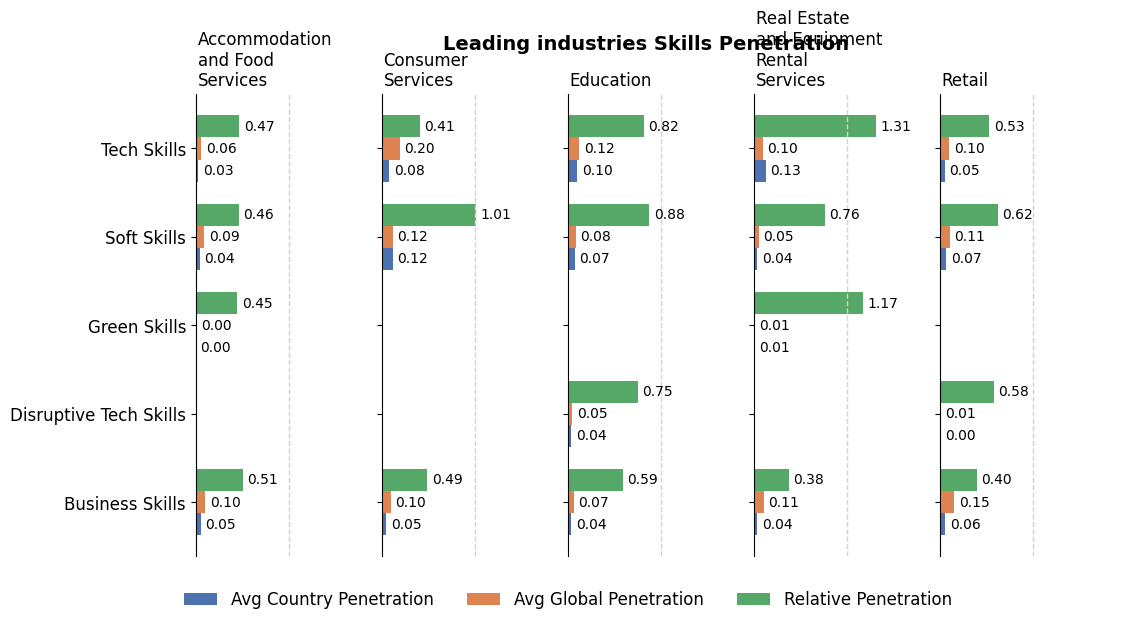

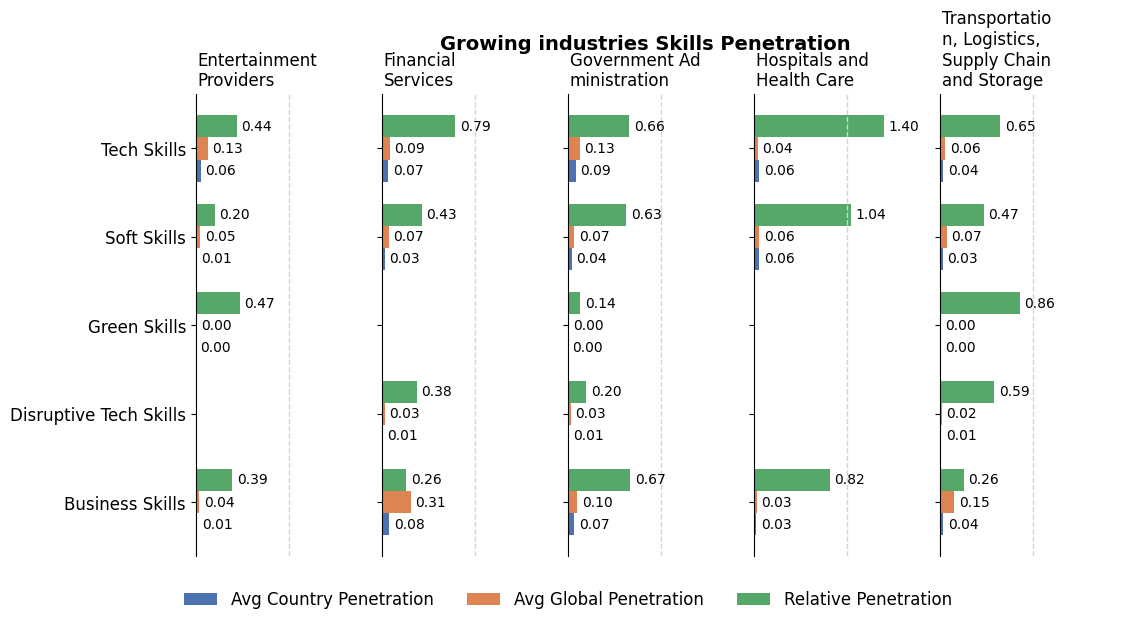

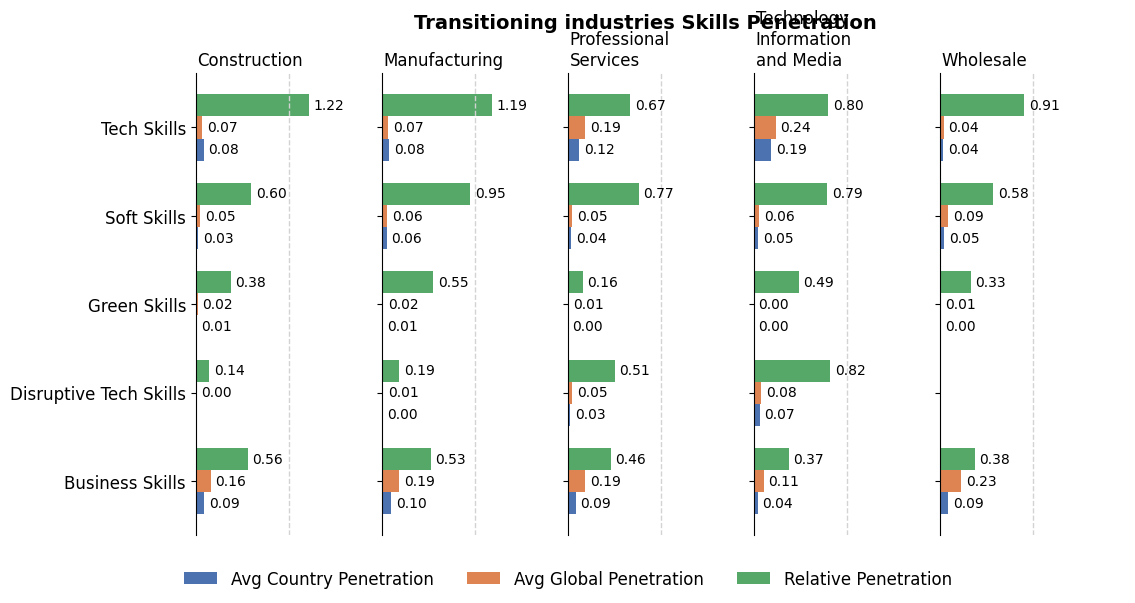

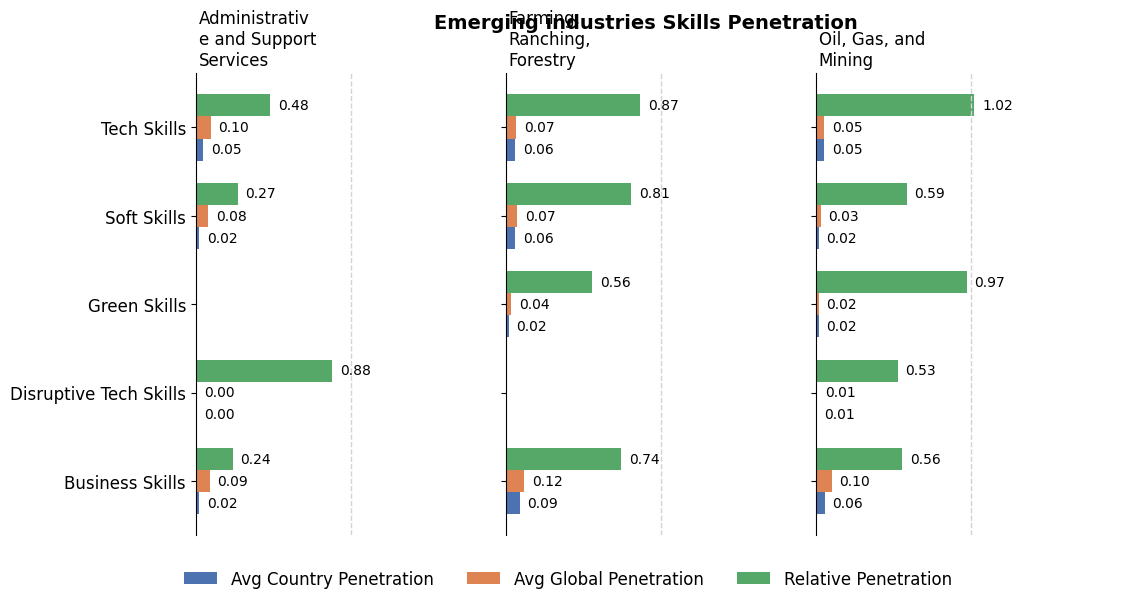

In [95]:
get_plot()

::::{tab-set}
:::{tab-item} Leading Industries
![leading_industries_skills_penetration.png](../../docs/images/Algeria/leading_industries_skills_penetration.png)
:::
:::{tab-item} Growing Industries
![growing_industries_skills_penetration.png](../../docs/images/Algeria/growing_industries_skills_penetration.png)
:::
:::{tab-item} Transitioning Industries
![transitioning_industries_skills_penetration.png](../../docs/images/Algeria/transitioning_industries_skills_penetration.png)
:::
:::{tab-item} Emerging Industries
![emerging_industries_skills_penetration.png](../../docs/images/Algeria/emerging_industries_skills_penetration.png)
:::
::::


> Overall, Algeria’s workforce shows strength in traditional and technical fields but lags in **green** and **advanced digital skills**, signaling an opportunity for **targeted reskilling** to drive future competitiveness.
